# LG3 Dataset Visualization Demo

원시 CSV에서 선택 컬럼을 확인하고, 가공된 데이터가 어떻게 변하는지 비교합니다.
- 1) 원시 데이터의 특정 컬럼 시각화
- 2) 가공 데이터(prepare 결과)에서 동일 컬럼 시각화
- 3) 전체 컬럼 중 4~5개를 랜덤 선택하여 50 스텝 구간을 표시


In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths (edit if needed)
RAW_EREPORT_DIR = "../../data/elec1_f2/EREPORT"
RAW_SMARTCARE_DIR = "../../data/elec1_f2/SMARTCARE"
PROCESSED_CSV = "../data/processed/lg3_train.csv"

# Column selection for raw vs processed comparison
RAW_COLUMN = "Power"

# Random window settings
RANDOM_WINDOW_LEN = 50
RANDOM_FEATURE_COUNT = 5


In [2]:
import os
import pandas as pd

def print_split_ranges(input_dir="../data/processed"):
    for split in ["train", "val", "test"]:
        path = os.path.join(input_dir, f"lg3_{split}.csv")
        if not os.path.exists(path):
            print(split, "missing", path)
            continue
        df = pd.read_csv(path, index_col=0, parse_dates=True)
        if df.empty:
            print(split, "empty")
            continue
        print(split, df.index.min(), "->", df.index.max())

print_split_ranges()

train 2025-08-01 13:15:00 -> 2025-10-07 06:00:00
val 2025-10-07 06:15:00 -> 2025-10-16 22:45:00
test 2025-10-16 23:00:00 -> 2025-11-20 23:45:00


In [3]:
def load_any_raw_csv(folder):
    files = sorted([f for f in os.listdir(folder) if f.endswith('.csv')])
    if not files:
        raise FileNotFoundError(f"No CSV files found in {folder}")
    return os.path.join(folder, files[0])

def load_raw_with_datetime(path):
    df = pd.read_csv(path)
    if 'Time' not in df.columns:
        raise ValueError(f"No 'Time' column in {path}")
    # Extract date from filename (YYYYMMDD)
    date = pd.to_datetime(''.join([c for c in os.path.basename(path) if c.isdigit()])[:8], format='%Y%m%d')
    df['Timestamp'] = pd.to_datetime(date.strftime('%Y-%m-%d') + ' ' + df['Time'].astype(str), errors='coerce')
    df = df.dropna(subset=['Timestamp'])
    df = df.set_index('Timestamp')
    return df

def random_window(df, window_len):
    if len(df) <= window_len:
        return df
    start = random.randint(0, len(df) - window_len)
    return df.iloc[start : start + window_len]


## 1) 원시 데이터에서 원하는 컬럼 확인

- EREPORT/SMARTCARE 중 하나를 선택해 특정 컬럼을 확인합니다.

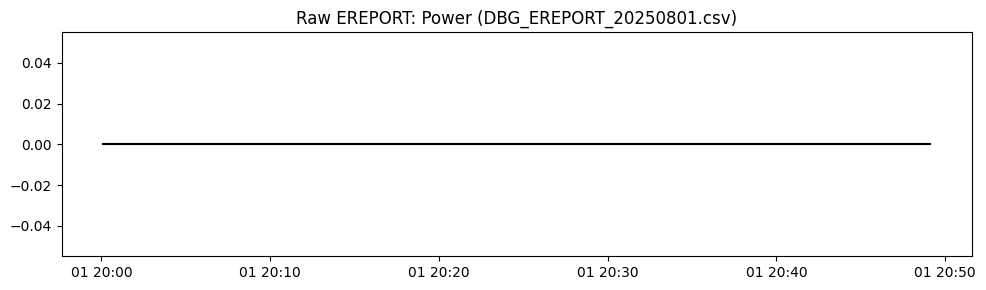

In [4]:
raw_path = load_any_raw_csv(RAW_EREPORT_DIR)
raw_df = load_raw_with_datetime(raw_path)

if RAW_COLUMN not in raw_df.columns:
    raise ValueError(f"'{RAW_COLUMN}' not in raw columns: {raw_df.columns.tolist()}")

raw_seg = random_window(raw_df[[RAW_COLUMN]].dropna(), RANDOM_WINDOW_LEN)

plt.figure(figsize=(10, 3))
plt.plot(raw_seg.index, raw_seg[RAW_COLUMN], color='black')
plt.title(f"Raw EREPORT: {RAW_COLUMN} ({os.path.basename(raw_path)})")
plt.tight_layout()
plt.show()


## 2) 가공 데이터에서 동일 컬럼 확인

- prepare 결과 CSV에서 같은 컬럼의 변화를 확인합니다.

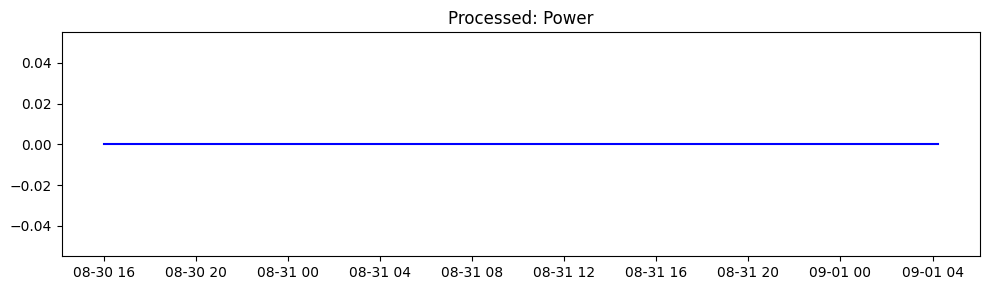

In [5]:
proc_df = pd.read_csv(PROCESSED_CSV, index_col=0, parse_dates=True)
if RAW_COLUMN not in proc_df.columns:
    raise ValueError(f"'{RAW_COLUMN}' not in processed columns: {proc_df.columns.tolist()}")

proc_seg = random_window(proc_df[[RAW_COLUMN]].dropna(), RANDOM_WINDOW_LEN)

plt.figure(figsize=(10, 3))
plt.plot(proc_seg.index, proc_seg[RAW_COLUMN], color='blue')
plt.title(f"Processed: {RAW_COLUMN}")
plt.tight_layout()
plt.show()


In [6]:
print('Processed columns:', proc_df.columns.tolist())
print('Numeric columns:', proc_df.select_dtypes(include=[np.number]).columns.tolist())


Processed columns: ['Capa_Cooling', 'MFR_068', 'Rop', 'Comp1 Hz_1', 'Comp1 Hz_0', 'Power', 'VAP_Entha', 'LIQ_Entha', 'cycle', 'Tcond', 'SCEEV_M', 'Tod', 'day_sin', 'day_cos', 'week_sin', 'week_cos']
Numeric columns: ['Capa_Cooling', 'MFR_068', 'Rop', 'Comp1 Hz_1', 'Comp1 Hz_0', 'Power', 'VAP_Entha', 'LIQ_Entha', 'cycle', 'Tcond', 'SCEEV_M', 'Tod', 'day_sin', 'day_cos', 'week_sin', 'week_cos']


## 3) 전체 컬럼 중 랜덤 4~5개 시각화

- 실행할 때마다 랜덤 컬럼을 선택
- 랜덤한 연속 구간(기본 50 스텝)을 시각화

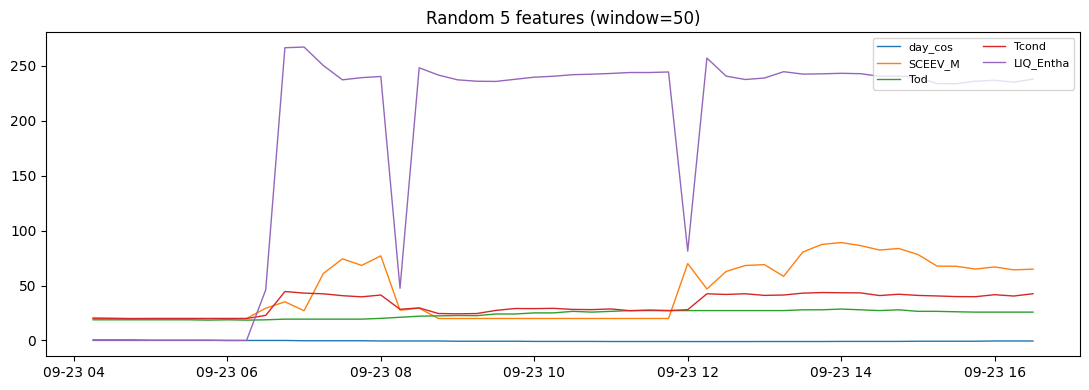

In [7]:
numeric_cols = proc_df.select_dtypes(include=[np.number]).columns.tolist()
if not numeric_cols:
    raise ValueError("No numeric columns in processed CSV")

k = min(RANDOM_FEATURE_COUNT, len(numeric_cols))
chosen = random.sample(numeric_cols, k=k)

seg = random_window(proc_df[chosen].dropna(), RANDOM_WINDOW_LEN)

plt.figure(figsize=(11, 4))
for col in chosen:
    plt.plot(seg.index, seg[col], linewidth=1.0, label=col)
plt.title(f"Random {k} features (window={len(seg)})")
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.tight_layout()
plt.show()
